# Plain vs. Skip Deep Decoder

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


In [2]:
def myimgshow(plt,img):
    plt.gray()
    plt.rcParams["figure.figsize"] = (8,8)
    plt.imshow(np.clip(img[0],0,1),interpolation='nearest')

## Load image

In [3]:
path = './test_data/'
#img_name = "phantom256"
img_name = "brain_sagittal.jpg"
img_path = path + img_name #+ ".png"
img_pil = Image.open(img_path)
img_np = np.array([pil_to_np(img_pil)[0]])
img_np = img_np / np.max(img_np)
img_var = np_to_var(img_np).type(dtype)

In [4]:
img_np.shape,img_var.shape

((1, 256, 256), torch.Size([1, 1, 256, 256]))

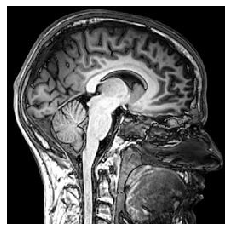

In [5]:
myimgshow(plt,img_np)
plt.axis('off')
#plt.savefig('exp_vis_sub'+img_name+'_final.png')
plt.show()

## Define network ant train it

In [ ]:
skip_psnr = []
skip_params = []
plain_psnr = []
plain_params = []
output_depth = img_np.shape[0]
num_channels = 64
rnd = 500
numit = 30000
rn = 0.001
maxv = np.max(img_np)
in_size = [32,32]
out_size = img_np[0].shape
for num_layers in [3,4,5,6,7,8]:
    
    skipnet = skipdecoder(out_size,in_size,output_depth,num_layers,num_channels,skips=True).type(dtype)
    skip_params.append(num_param(skipnet))
    
    plainnet = skipdecoder(out_size,in_size,output_depth,num_layers,num_channels,skips=False).type(dtype)
    plain_params.append(num_param(plainnet))
    
    print("#layers:",num_layers)
    print("train skip") 
    mse_n, mse_t, skipni, skipnet = fit( in_size = in_size,
                            num_channels=[num_channels]*(num_layers-1),
                            reg_noise_std=rn,
                            reg_noise_decayevery = rnd,
                            num_iter=numit,
                            LR=0.01,
                            img_noisy_var=img_var,
                            net=skipnet,
                            img_clean_var=img_var,
                            find_best=True,
                            )
    out_img_np = skipnet( skipni.type(dtype) ).data.cpu().numpy()[0]
    skip_psnr.append(psnr(img_np,out_img_np,maxv))
    print("\n")
    
    print("train plain")    
    mse_n, mse_t, plainni, plainnet = fit( in_size = in_size,
                            num_channels=[num_channels]*(num_layers-1),
                            reg_noise_std=rn,
                            reg_noise_decayevery = rnd,
                            num_iter=numit,
                            LR=0.01,
                            img_noisy_var=img_var,
                            net=plainnet,
                            net_input = skipni ,
                            img_clean_var=img_var,
                            find_best=True,
                            #orth_reg=0.1,
                            )    
    out_img_np = plainnet( plainni.type(dtype) ).data.cpu().numpy()[0]
    plain_psnr.append(psnr(img_np,out_img_np,maxv)) 
    print("\n")

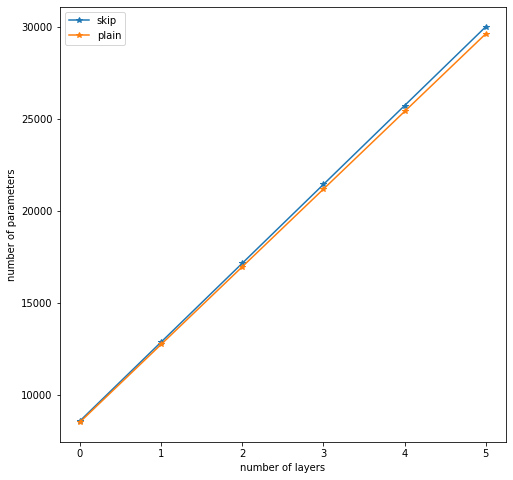

In [12]:
plt.plot(skip_params,"-*",label="skip")
plt.plot(plain_params,"-*",label="plain")
plt.xlabel("number of layers")
plt.ylabel("number of parameters")
plt.legend()
plt.show()

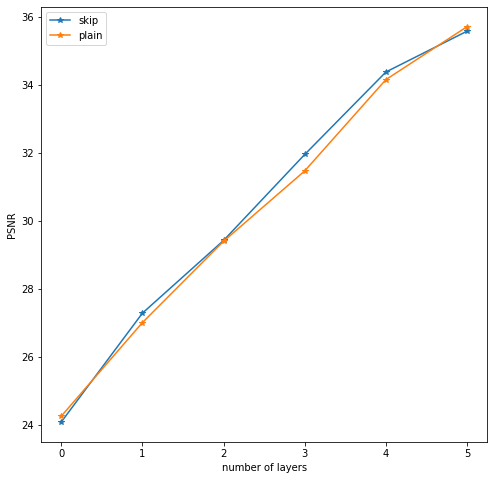

In [13]:
plt.plot(skip_psnr,"-*",label="skip")
plt.plot(plain_psnr,"-*",label="plain")
plt.xlabel("number of layers")
plt.ylabel("PSNR")
plt.legend()
plt.show()

### Visualize Skipnet Activations and Output (for the last setup (last number of layers (8)))

##### skip deep decoder representation for the input image

Skip-Deep-Decoder representation of the image, SNR: 35.57867184951747


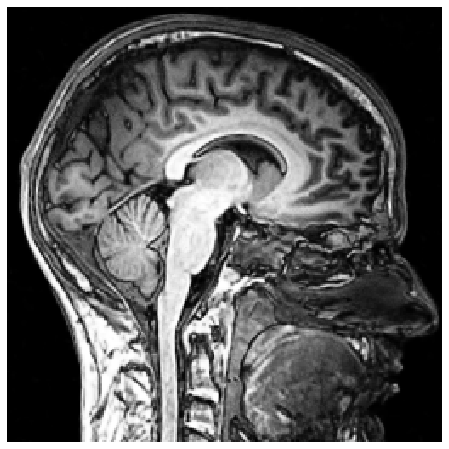

In [14]:
out_img_np = skipnet( skipni.type(dtype) ).data.cpu().numpy()[0]
maxv = np.max(img_np)
print("Skip-Deep-Decoder representation of the image, SNR: " + str(psnr(img_np,out_img_np,maxv)))
myimgshow(plt,out_img_np)
plt.axis('off')
plt.show()

In [15]:
def apply_until(net_input,net,n = 100):
    # gets intermediate outputs from the network
    if n == 0:
        return net_input
    else:
        print("output up to block{}: {}".format(n,net[n-1]))
        return net[:n](net_input.type(dtype))

def plot_tensor(out,nrows=8):
    imgs = [img for img in out.data.cpu().numpy()[0]]
    fig = plot_image_grid(imgs,nrows=nrows)
    plt.show()

##### individual channels per layer

output up to block4: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


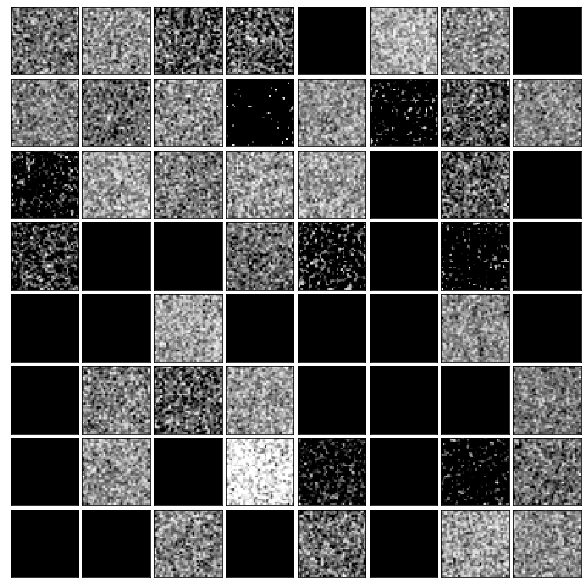

output up to block8: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


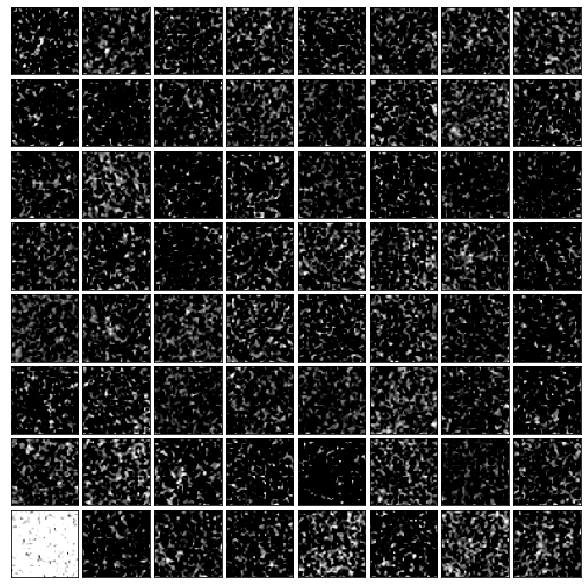

output up to block12: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


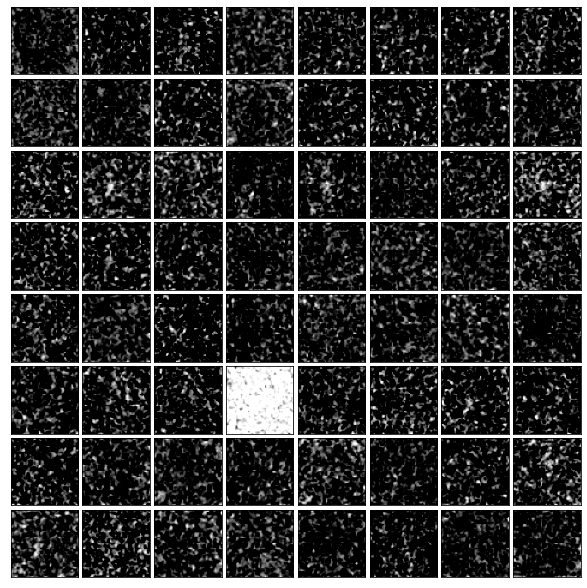

output up to block16: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


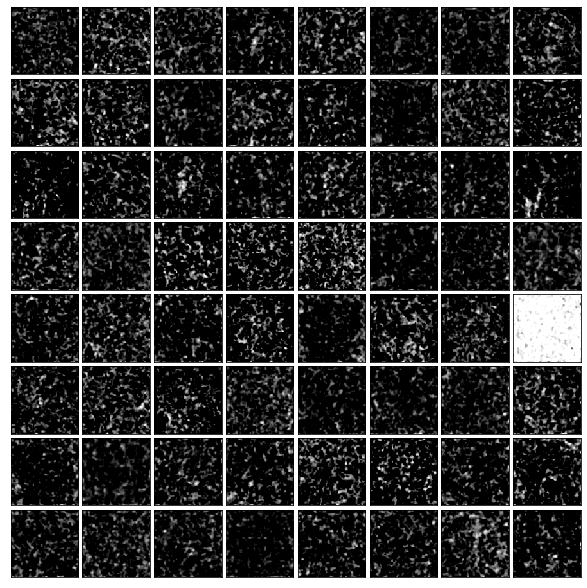

output up to block20: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


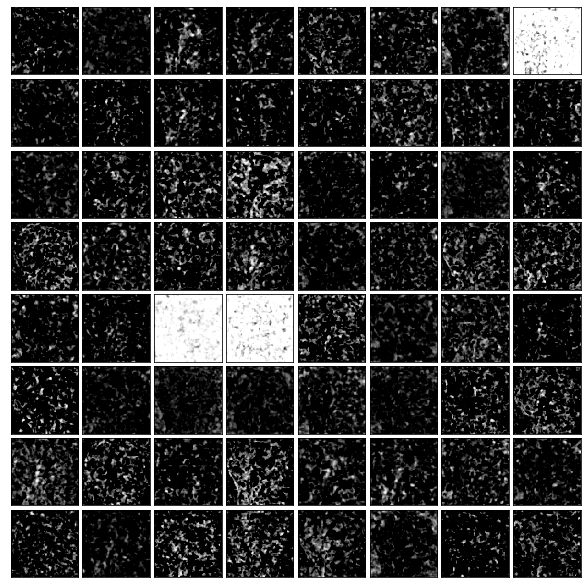

output up to block24: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


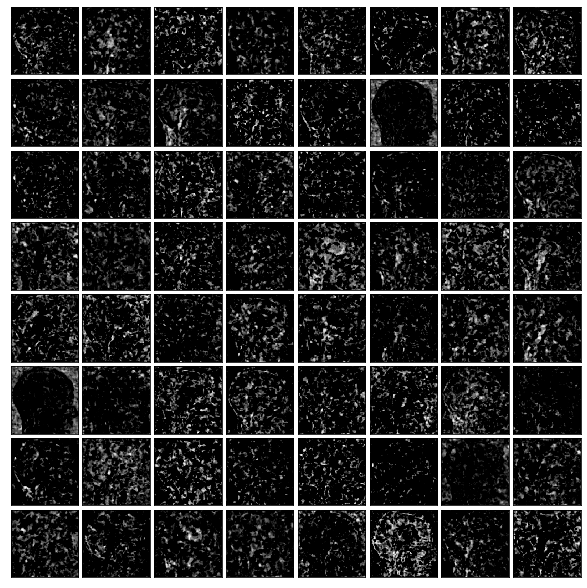

output up to block28: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


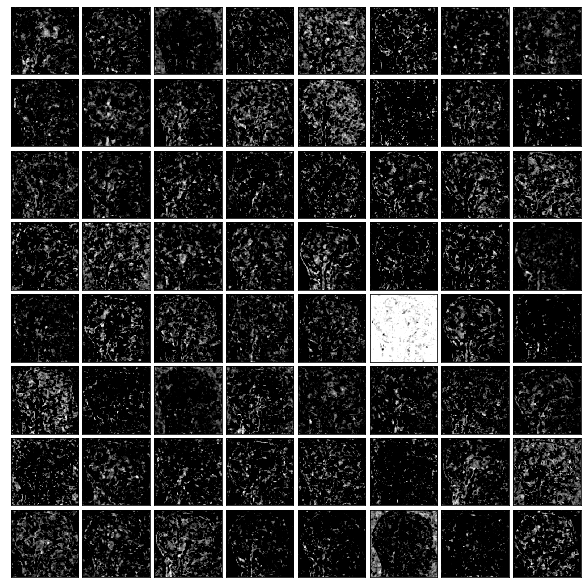

In [16]:
intermed_layers = skipnet.layer_inds + [skipnet.layer_inds[-1]+(skipnet.layer_inds[-1]-skipnet.layer_inds[-2])] # concat the index of the last layer before the combining layer manually

for n in intermed_layers:
        out = apply_until(skipni,skipnet.net1,n)
        plot_tensor(out)

##### mean over channels per layer

layer4
output up to block4: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


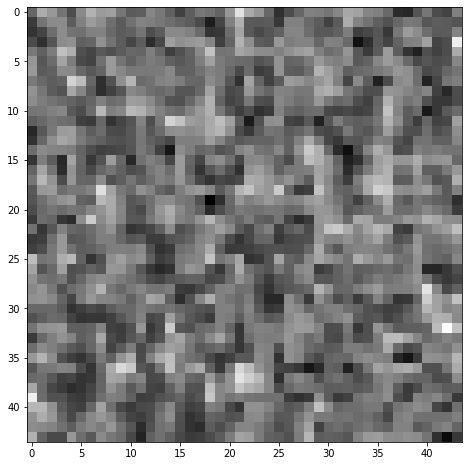

layer8
output up to block8: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


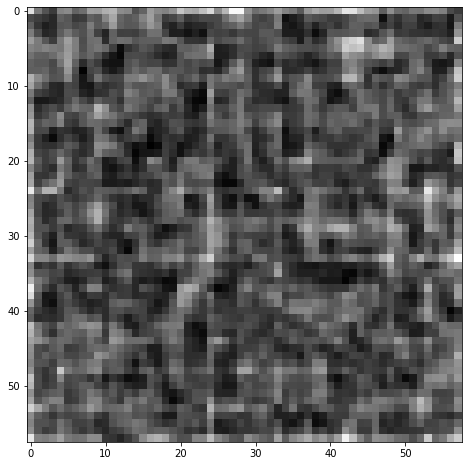

layer12
output up to block12: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


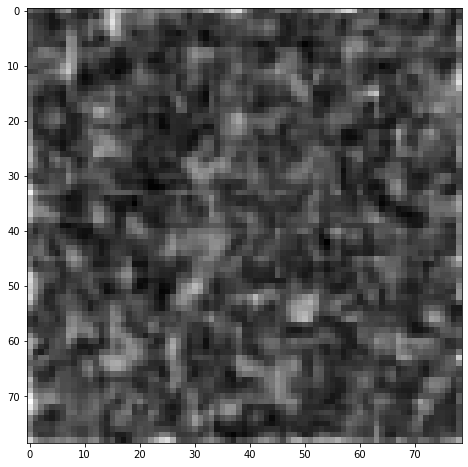

layer16
output up to block16: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


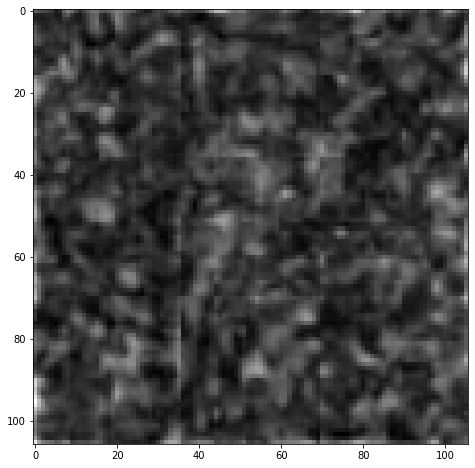

layer20
output up to block20: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


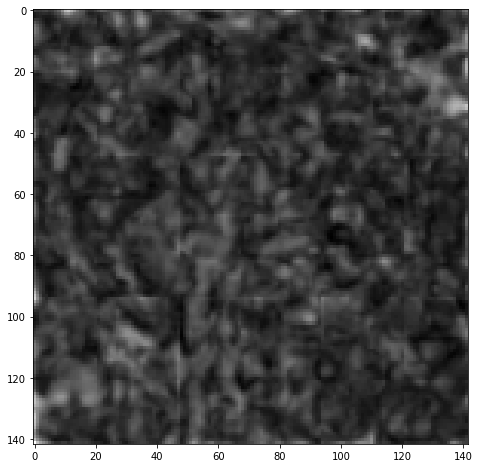

layer24
output up to block24: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


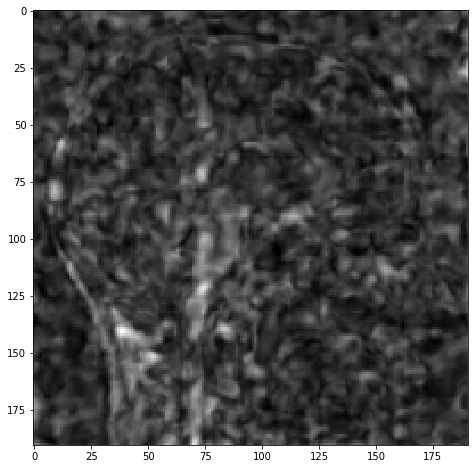

layer28
output up to block28: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


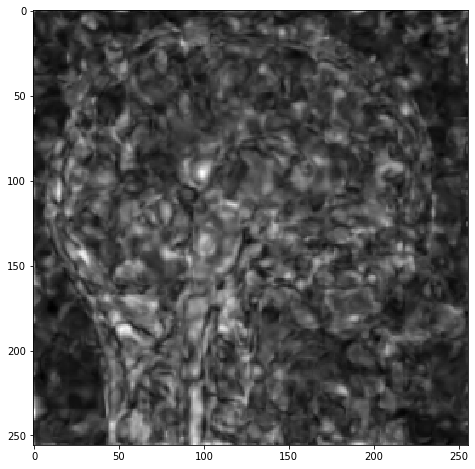

In [17]:
for n in intermed_layers:
    print("layer{}".format(n))
    out = apply_until(skipni,skipnet.net1,n)
    plt.imshow(out.mean(1)[0].data.cpu())
    plt.show()

##### original image

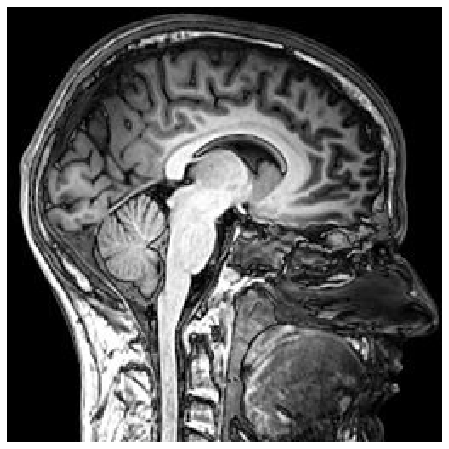

In [16]:
myimgshow(plt,img_np)
plt.axis('off')
#plt.savefig('exp_vis_sub'+img_name+'_final.png')
plt.show()